In [1]:
# general libs
import os
import random
import shutil
import gdown
import glob
import numpy as np
import logging
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm
from datetime import datetime
from pathlib import Path

# torch libs
import torch
import torchvision

from torchinfo import summary
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# set seed 
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# date info
now_str = datetime.now().strftime("%a, %d %b %Y %H:%M:%S")
date_str = datetime.now().strftime("%Y%m%d")
datetime_str = datetime.now().strftime("%Y%m%d_%H%M%S")

# current dirctory
current_dir = os.getcwd()
current_dirname = os.path.basename(current_dir)

# project directory
project_name = f"06_transfer_learning_feature_extractiion_fine_tuning_{date_str}"

# data directory
DATA_DIR = Path('../../data/')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# log directory
LOG_DIR = Path(f'../../logs/{project_name}')
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir(parents=True, exist_ok=True)

LOG_FILE_PATH = LOG_DIR.joinpath(f"06_transfer_learning_feature_extractiion_fine_tuning__{datetime_str}.log")

# history curves, prediction results - feature extraction
HISTORY_CURVES_FEATURE_EXTRACTION_PATH = LOG_DIR.joinpath(f"history_curves_feature_extraction_{datetime_str}.png")
PREDICTION_RESULTS_FEATURE_EXTRACTION_FILE_PATH = LOG_DIR.joinpath(f"prediction_results_feature_extraction_{datetime_str}.png")

# history curves, prediction results - fine-tuning
HISTORY_CURVES_FINE_TUNING_PATH = LOG_DIR.joinpath(f"history_curves_fine_tuning_{datetime_str}.png")
PREDICTION_RESULTS_FINE_TUNING_FILE_PATH = LOG_DIR.joinpath(f"prediction_results_fine_tuning_{datetime_str}.png")

# model directory
MODEL_DIR = Path(f'../../models/{project_name}')
if not MODEL_DIR.is_dir():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

# saved model - feature extraction
MODEL_FEATURE_EXTRACTION_STATE_DICT_FILE_PATH = MODEL_DIR.joinpath(f"feature_extraction_state_dict_{datetime_str}.pt")
MODEL_FEATURE_EXTRACTION_FULL_MODEL_FILE_PATH = MODEL_DIR.joinpath(f"feature_extraction_full_model_{datetime_str}.pt")

# saved model - fine-tuning
MODEL_FINE_TUNING_STATE_DICT_FILE_PATH = MODEL_DIR.joinpath(f"fine_tuning_state_dict_{datetime_str}.pt")
MODEL_FINE_TUNING_FULL_MODEL_FILE_PATH = MODEL_DIR.joinpath(f"fine_tuning_full_model_{datetime_str}.pt")

# tensorboard directory
TENSORBOARD_DIR = Path(f'../../tensorboards/{project_name}')
if not TENSORBOARD_DIR.is_dir():
    TENSORBOARD_DIR.mkdir(parents=True, exist_ok=True)

# tensorboards for feature extraction, fine_tuning
TENSORBOARD_FEATURE_EXTRACTION_DIR = MODEL_DIR.joinpath(f"feature_extraction_{datetime_str}")
TENSORBOARD_FINE_TUNING_DIR = MODEL_DIR.joinpath(f"fine_tuning_{datetime_str}")

# logging configuration
# logging.basicConfig(
#     level=logging.INFO,
#     datefmt="%a, %d %b %Y %H:%M:%S",
#     format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
#     handlers=[
#         logging.FileHandler(filename=LOG_FILE_PATH, mode="w"),
#         logging.StreamHandler()
#     ]
# )

# created date
print(f"Created date: Tue, 05 Sep 2023 10:58:54")

# modified date
print(f"Modified date: {now_str}")

# version info
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

# num of gpus
num_gpus = torch.cuda.device_count()
print(f"GPUs: {num_gpus}")

# cuda version
cuda_version = torch.version.cuda 
print(f"cuda version: {cuda_version}")


## dataset
# urls
DATASET_10_PERCENT_URL = "https://drive.google.com/uc?id=17Yw1PGyDGpwV77Ds6VDBQ7Iv9Q2rQR6P"
DATASET_FULL_URL = "https://drive.google.com/uc?id=1h9Zvm0UKeGMk8hXSdfCJ5E1hIgxvQHN6"

# dataset zipfile names
DATASET_10_PERCENT_ZIPFILE_NAME = "10_food_classes_10_percent.zip"
DATASET_FULL_ZIPFILE_NAME = "food10.zip"

# dataset folder names
DATASET_10_PERCENT_FOLDER_NAME = "10_food_classes_10_percent"
DATASET_FULL_FOLDER_NAME = "food10"

# dataset zipfile paths
DATASET_10_PERCENT_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_10_PERCENT_ZIPFILE_NAME)
DATASET_FULL_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_FULL_ZIPFILE_NAME)

# dataset folder paths
DATASET_10_PERCENT_FOLDER_PATH = DATA_DIR.joinpath(DATASET_10_PERCENT_FOLDER_NAME)
DATASET_FULL_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FULL_FOLDER_NAME)

# download 10 percents dataset
if not DATASET_10_PERCENT_ZIPFILE_PATH.is_file():
    print(f"The {DATASET_10_PERCENT_ZIPFILE_NAME} is downloading...")
    try:
        gdown.download(url=DATASET_10_PERCENT_URL, output=str(DATASET_10_PERCENT_ZIPFILE_PATH))
        print(f"The {DATASET_10_PERCENT_ZIPFILE_NAME} downloaded successfully.")
    except Exception as error:
        print(f"Caught this error: {error}")
else:
    print(f"The {DATASET_10_PERCENT_ZIPFILE_NAME} already exists")


# download full dataset
if not DATASET_FULL_ZIPFILE_PATH.is_file():
    print(f"The {DATASET_FULL_ZIPFILE_NAME} is downloading...")
    try:
        gdown.download(url=DATASET_FULL_URL, output=str(DATASET_FULL_ZIPFILE_PATH))
        print(f"The {DATASET_FULL_ZIPFILE_NAME} downloaded successfully.")
    except Exception as error:
        print(f"Caught this error: {error}")
else:
    print(f"The {DATASET_FULL_ZIPFILE_NAME} already exists")


# extract 10 percents dataset
if not DATASET_10_PERCENT_FOLDER_PATH.is_dir():
    print(f"The {DATASET_10_PERCENT_ZIPFILE_NAME} is extracting...")
    try:
        gdown.extractall(path=str(DATASET_10_PERCENT_ZIPFILE_PATH), to=str(DATA_DIR))
        print(f"The {DATASET_10_PERCENT_ZIPFILE_NAME} extracted successfully.")
    except Exception as error:
        print(f"Caught this error: {error}")
else:
    print(f"The {DATASET_10_PERCENT_FOLDER_NAME} already exists")


# extract full dataset
if not DATASET_FULL_FOLDER_PATH.is_dir():
    print(f"The {DATASET_FULL_ZIPFILE_NAME} is extracting...")
    try:
        gdown.extractall(path=str(DATASET_FULL_ZIPFILE_PATH), to=str(DATA_DIR))
        print(f"The {DATASET_FULL_ZIPFILE_NAME} extracted successfully.")
    except Exception as error:
        print(f"Caught this error: {error}")
else:
    print(f"The {DATASET_FULL_FOLDER_NAME} already exists")



Created date: Tue, 05 Sep 2023 10:58:54
Modified date: Thu, 07 Sep 2023 18:05:37
torch version: 1.12.1
torchvision version: 0.13.1
device: cuda
GPUs: 4
cuda version: 11.3
The 10_food_classes_10_percent.zip already exists
The food10.zip already exists
The 10_food_classes_10_percent already exists
The food10 already exists


`Dataset Preparing`

In [2]:
def create_validation_data(dataset_dir: Path, ratio: float = 0.1) -> Path:

    # original - dataset dir
    original_dataset_dir = dataset_dir.joinpath("train")

    # val directory
    val_dir = dataset_dir.joinpath("val")
    if not val_dir.is_dir():
        val_dir.mkdir(parents=True, exist_ok=True)

        # class dirs
        class_dirs = [entry.path for entry in os.scandir(original_dataset_dir)]
        print(f"len(class_dirs): {len(class_dirs)}")

        # looping each class directory
        for class_dir in class_dirs:
        
            # all files in the dataset directory
            filepaths = glob.glob(os.path.join(class_dir, f"*jpg"))

            # total files
            total_files = len(filepaths)
            
            # selected files by ratio
            selected_files = int(ratio * total_files)
            
            print(f"total_files: {total_files}")
            print(f"selected files: {selected_files}")
            
            # randomly sample
            selected_filepaths = random.sample(filepaths, k= selected_files)

            # looping the selected files
            for selected_filepath in selected_filepaths:
                
                # class name
                file_class_name = Path(selected_filepath).parents[0].name
                
                # var class directory
                val_class_dir = val_dir.joinpath(file_class_name)
                if not val_class_dir.is_dir():
                    val_class_dir.mkdir(parents=True, exist_ok=True)

                # copy files to val directory
                print(f"Moving a file from {selected_filepath} to {val_class_dir} directory")
                shutil.move(src=selected_filepath, dst=val_class_dir)
    else:
        print(f"The validation directory {val_dir} already exists. Skipped this process.")

    return val_dir

In [3]:
# 10 percents - train dir
train_dir_10_percent = DATASET_10_PERCENT_FOLDER_PATH.joinpath("train")

# 10 percents - test dir
test_dir_10_percent = DATASET_10_PERCENT_FOLDER_PATH.joinpath("test")

# 10 percents - val dir
val_dir_10_percent = create_validation_data(dataset_dir= DATASET_10_PERCENT_FOLDER_PATH)

# full - train dir
train_dir_full = DATASET_FULL_FOLDER_PATH.joinpath("train")

# full - test dir
test_dir_full = DATASET_FULL_FOLDER_PATH.joinpath("test")

# full - val dir
val_dir_full = create_validation_data(dataset_dir= DATASET_FULL_FOLDER_PATH)

The validation directory ../../data/10_food_classes_10_percent/val already exists. Skipped this process.
The validation directory ../../data/food10/val already exists. Skipped this process.


In [4]:
# walk through the 10 percents - train dir
for filepaths, dirnames, filenames in os.walk(train_dir_10_percent):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {filepaths}")

There are 68 images in ../../data/10_food_classes_10_percent/train/fried_rice
There are 68 images in ../../data/10_food_classes_10_percent/train/ramen
There are 68 images in ../../data/10_food_classes_10_percent/train/hamburger
There are 68 images in ../../data/10_food_classes_10_percent/train/pizza
There are 68 images in ../../data/10_food_classes_10_percent/train/sushi
There are 68 images in ../../data/10_food_classes_10_percent/train/chicken_wings
There are 68 images in ../../data/10_food_classes_10_percent/train/ice_cream
There are 68 images in ../../data/10_food_classes_10_percent/train/grilled_salmon
There are 68 images in ../../data/10_food_classes_10_percent/train/steak
There are 68 images in ../../data/10_food_classes_10_percent/train/chicken_curry


In [5]:
# walk through the 10 percents - test dir
for filepaths, dirnames, filenames in os.walk(test_dir_10_percent):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {filepaths}")

There are 250 images in ../../data/10_food_classes_10_percent/test/fried_rice
There are 250 images in ../../data/10_food_classes_10_percent/test/ramen
There are 250 images in ../../data/10_food_classes_10_percent/test/hamburger
There are 250 images in ../../data/10_food_classes_10_percent/test/pizza
There are 250 images in ../../data/10_food_classes_10_percent/test/sushi
There are 250 images in ../../data/10_food_classes_10_percent/test/chicken_wings
There are 250 images in ../../data/10_food_classes_10_percent/test/ice_cream
There are 250 images in ../../data/10_food_classes_10_percent/test/grilled_salmon
There are 250 images in ../../data/10_food_classes_10_percent/test/steak
There are 250 images in ../../data/10_food_classes_10_percent/test/chicken_curry


In [6]:
# walk through the 10 percents - val dir
for filepaths, dirnames, filenames in os.walk(val_dir_10_percent):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {filepaths}")

There are 7 images in ../../data/10_food_classes_10_percent/val/fried_rice
There are 7 images in ../../data/10_food_classes_10_percent/val/ramen
There are 7 images in ../../data/10_food_classes_10_percent/val/hamburger
There are 7 images in ../../data/10_food_classes_10_percent/val/pizza
There are 7 images in ../../data/10_food_classes_10_percent/val/sushi
There are 7 images in ../../data/10_food_classes_10_percent/val/chicken_wings
There are 7 images in ../../data/10_food_classes_10_percent/val/ice_cream
There are 7 images in ../../data/10_food_classes_10_percent/val/grilled_salmon
There are 7 images in ../../data/10_food_classes_10_percent/val/steak
There are 7 images in ../../data/10_food_classes_10_percent/val/chicken_curry


In [7]:
# walk through the full - train dir
for filepaths, dirnames, filenames in os.walk(train_dir_full):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {filepaths}")

There are 675 images in ../../data/food10/train/fried_rice
There are 675 images in ../../data/food10/train/ramen
There are 675 images in ../../data/food10/train/hamburger
There are 675 images in ../../data/food10/train/pizza
There are 675 images in ../../data/food10/train/sushi
There are 675 images in ../../data/food10/train/chicken_wings
There are 675 images in ../../data/food10/train/ice_cream
There are 675 images in ../../data/food10/train/grilled_salmon
There are 675 images in ../../data/food10/train/steak
There are 675 images in ../../data/food10/train/chicken_curry


In [8]:
# walk through the full - test dir
for filepaths, dirnames, filenames in os.walk(test_dir_full):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {filepaths}")

There are 250 images in ../../data/food10/test/fried_rice
There are 250 images in ../../data/food10/test/ramen
There are 250 images in ../../data/food10/test/hamburger
There are 250 images in ../../data/food10/test/pizza
There are 250 images in ../../data/food10/test/sushi
There are 250 images in ../../data/food10/test/chicken_wings
There are 250 images in ../../data/food10/test/ice_cream
There are 250 images in ../../data/food10/test/grilled_salmon
There are 250 images in ../../data/food10/test/steak
There are 250 images in ../../data/food10/test/chicken_curry


In [9]:
# walk through the full - val dir
for filepaths, dirnames, filenames in os.walk(val_dir_full):
    if len(filenames) > 0:
        print(f"There are {len(filenames)} images in {filepaths}")

There are 75 images in ../../data/food10/val/fried_rice
There are 75 images in ../../data/food10/val/ramen
There are 75 images in ../../data/food10/val/hamburger
There are 75 images in ../../data/food10/val/pizza
There are 75 images in ../../data/food10/val/sushi
There are 75 images in ../../data/food10/val/chicken_wings
There are 75 images in ../../data/food10/val/ice_cream
There are 75 images in ../../data/food10/val/grilled_salmon
There are 75 images in ../../data/food10/val/steak
There are 75 images in ../../data/food10/val/chicken_curry


`Dataset Preprocessing`

In [10]:
# batch size 
batch_size = 128

# train transform
train_transform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# test transform
test_transform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# validation transform
val_transform = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 10 percent dataset

# train 10 percent dataset
train_10_percent_dataset = ImageFolder(root=train_dir_10_percent, transform=train_transform)

# test 10 percent dataset
test_10_percent_dataset = ImageFolder(root=test_dir_10_percent, transform=test_transform)

# val 10 percent dataset
val_10_percent_dataset = ImageFolder(root=val_dir_10_percent, transform=val_transform)

# train 10 percent dataloader 
train_10_percent_dataloader = DataLoader(dataset=train_10_percent_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True)

# test 10 percent dataloader 
test_10_percent_dataloader = DataLoader(dataset=test_10_percent_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True)
# val 10 percent dataloader 
val_10_percent_dataloader = DataLoader(dataset=val_10_percent_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True)



## full dataset
# train full dataset
train_full_dataset = ImageFolder(root=train_dir_full, transform=train_transform)

# test full dataset
test_full_dataset = ImageFolder(root=test_dir_full, transform=test_transform)

# val full dataset
val_full_dataset = ImageFolder(root=val_dir_full, transform=val_transform)


# train full dataloader 
train_full_dataloader = DataLoader(dataset=train_full_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True)

# test full dataloader 
test_full_dataloader = DataLoader(dataset=test_full_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True)
# val full dataloader 
val_full_dataloader = DataLoader(dataset=val_full_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         pin_memory=True)

In [11]:
# class names
class_names = train_10_percent_dataset.classes
print(f"len(class_names): {len(class_names)}")

len(class_names): 10


`Pretrained Models - Transfer Learning`

In [12]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT

efficientnet_b1 = torchvision.models.efficientnet_b1(weights=weights)

# print(summary(model=efficientnet_b1, 
#         input_size=(32, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20, 
#         row_settings=["var_names"],
#         verbose=1))

efficientnet_b1.parameters()

<generator object Module.parameters at 0x7f9886ba9f20>

In [13]:
# freezing all parameters from the pretrained model `efficientnet_b1`
for layer_number, layer in enumerate(efficientnet_b1.parameters()):
    layer.requires_grad = False

# print(summary(model=efficientnet_b1, 
#         input_size=(32, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20, 
#         row_settings=["var_names"],
#         verbose=2))

#### `Feature Extraction `

In [14]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT

feature_extraction_efficientnet_b1 = torchvision.models.efficientnet_b1(weights=weights)

# freezing all parameters from the pretrained model `efficientnet_b1`
for layer_number, layer in enumerate(feature_extraction_efficientnet_b1.parameters()):
    layer.requires_grad = False

# adjust the classifier
feature_extraction_efficientnet_b1.classifier = torch.nn.Sequential(
    # Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release.
    # torch.nn.Dropout2d(p=0.5, inplace=True), 
    torch.nn.Dropout(p=0.5, inplace=True), 
    torch.nn.Linear(in_features=1280, out_features=len(class_names))
)

print(summary(model=feature_extraction_efficientnet_b1, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, 
        row_settings=["var_names"],
        verbose=2))

# print out the trainable params
# for name, param in feature_extraction_efficientnet_b1.named_parameters():
#     if param.requires_grad:
#         print(f"Trainable: {name} = {param.requires_grad}")


# feature_extraction_efficientnet_b1 = torch.nn.parallel.DataParallel(
#     module=feature_extraction_efficientnet_b1, 
#     device_ids=list(range(num_gpus)))

# send model to device 
feature_extraction_efficientnet_b1 = feature_extraction_efficientnet_b1.to(device)

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(params=feature_extraction_efficientnet_b1.parameters(), lr=0.001)

# epochs 
feature_extraction_epochs = 10

# history curve dict
history_curve_feature_extraction_dict = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": [],
}

## LOOPING
for epoch in tqdm(range(feature_extraction_epochs)):

    # start timer
    start_timer = timer()

    # TRAINING
    accumulated_train_loss = 0.0
    accumulated_train_accuracy = 0.0
    accumulated_train_batches = 0

    for inputs, outputs in train_10_percent_dataloader:

        # training mode
        feature_extraction_efficientnet_b1.train()

        # send data to device
        inputs, outputs = inputs.to(device), outputs.to(device)

        # forward pass
        y_logits = feature_extraction_efficientnet_b1(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss.data

        # calculate accuracy
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_accuracy += (acc / len(y_logits))

        # zero gradients
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    # EVALUATION
    feature_extraction_efficientnet_b1.eval()
    with torch.inference_mode():

        accumulated_test_loss = 0.0
        accumulated_test_accuracy = 0.0
        accumulated_test_batches = 0

        for inputs, outputs in test_10_percent_dataloader:


            # send data to device
            inputs, outputs = inputs.to(device), outputs.to(device)

            # forward pass
            y_logits = feature_extraction_efficientnet_b1(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss.data

            # calculate accuracy
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_accuracy += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1
    
    # end timer
    end_timer = timer()
    execution_time = end_timer = start_timer

    # train
    accuracy = accumulated_train_accuracy / accumulated_train_batches
    loss = accumulated_train_loss / accumulated_train_batches

    history_curve_feature_extraction_dict["accuracy"].append(round(accuracy, 3))
    history_curve_feature_extraction_dict["loss"].append(round(loss.cpu().numpy().item(), 3))

    # test
    val_accuracy = accumulated_test_accuracy / accumulated_test_batches
    val_loss = accumulated_test_loss / accumulated_test_batches

    history_curve_feature_extraction_dict["val_accuracy"].append(round(val_accuracy, 3))
    history_curve_feature_extraction_dict["val_loss"].append(round(val_loss.cpu().numpy().item(), 3))

    # print out
    print(f"Epoch: {epoch + 1} / {feature_extraction_epochs} | "
          f"Execution time: {execution_time: .2f}s | " 
          f"accuracy: {accuracy: .2f} | "
          f"loss: {loss: .3f} | "
          f"val_accuracy: {val_accuracy: .2f} | "
          f"val_loss: {val_loss: .2f}"
          )

# save the full model
torch.save(feature_extraction_efficientnet_b1, MODEL_FEATURE_EXTRACTION_FULL_MODEL_FILE_PATH)
if MODEL_FEATURE_EXTRACTION_FULL_MODEL_FILE_PATH.is_file():
    # getsize() returns in bytes 
    print(f"Size of the full feature extraction model: {os.path.getsize(MODEL_FEATURE_EXTRACTION_FULL_MODEL_FILE_PATH)  / (1024 * 1024): .2f} MB")

# save the state_dict
torch.save(feature_extraction_efficientnet_b1.state_dict(), MODEL_FEATURE_EXTRACTION_STATE_DICT_FILE_PATH)
if MODEL_FEATURE_EXTRACTION_STATE_DICT_FILE_PATH.is_file():
    # getsize() returns in bytes 
     print(f"Size of the state_dict feature extraction model: {os.path.getsize(MODEL_FEATURE_EXTRACTION_STATE_DICT_FILE_PATH) / (1024 * 1024): .2f} MB")

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─0.0.weight                                                                                      ├─864
│    └─0.1.weight                                                                                      ├─32
│    └─0.1.bias                                                                                        ├─32
│    └─1.0.block.0.0.weight                                                                            ├─288
│    └─1.0.block.0.1.weight                                                                            ├─32
│    └─1.0.block.0.1.bias                                     

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10 | Execution time:  792529.01s | accuracy:  0.13 | loss:  2.289 | val_accuracy:  0.27 | val_loss:  2.17
Epoch: 2 / 10 | Execution time:  792548.21s | accuracy:  0.21 | loss:  2.202 | val_accuracy:  0.39 | val_loss:  2.04
Epoch: 3 / 10 | Execution time:  792566.61s | accuracy:  0.32 | loss:  2.064 | val_accuracy:  0.48 | val_loss:  1.93
Epoch: 4 / 10 | Execution time:  792584.76s | accuracy:  0.41 | loss:  1.973 | val_accuracy:  0.57 | val_loss:  1.83
Epoch: 5 / 10 | Execution time:  792602.85s | accuracy:  0.42 | loss:  1.918 | val_accuracy:  0.61 | val_loss:  1.75
Epoch: 6 / 10 | Execution time:  792620.94s | accuracy:  0.51 | loss:  1.829 | val_accuracy:  0.62 | val_loss:  1.68
Epoch: 7 / 10 | Execution time:  792639.01s | accuracy:  0.49 | loss:  1.781 | val_accuracy:  0.63 | val_loss:  1.62
Epoch: 8 / 10 | Execution time:  792657.09s | accuracy:  0.53 | loss:  1.708 | val_accuracy:  0.64 | val_loss:  1.55
Epoch: 9 / 10 | Execution time:  792675.16s | accuracy:  0.55 | 

In [15]:
def display_history_curves(history_curve_dict: list, save_path: Path, type_name: str = "feature extraction"):

    # get current date
    now_str = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

    # plot title
    title = f"Transfer learning - {type_name} - {now_str}"

    # history curves info
    accuracy = history_curve_dict["accuracy"]
    loss = history_curve_dict["loss"]
    val_accuracy = history_curve_dict["val_accuracy"]
    val_loss = history_curve_dict["val_loss"]

    # list of epochs
    epochs = list(range(len(accuracy)))

    # create a plot 

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    # accuracy of the training set, and testing set
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, c="r", label = "Training dataset")
    plt.plot(epochs, val_accuracy, c="g", label = "Testing dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # loss of the training set, and testing set
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, c="r", label = "Training dataset")
    plt.plot(epochs, val_loss, c="g", label = "Testing dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.savefig(save_path, bbox_inches="tight")
    print(f"The history curves of the {type_name} is saved in {save_path}")


`HISTORY CURVES`

The history curves of the feature extraction is saved in ../../logs/06_transfer_learning_feature_extractiion_fine_tuning_20230907/history_curves_feature_extraction_20230907_180537.png


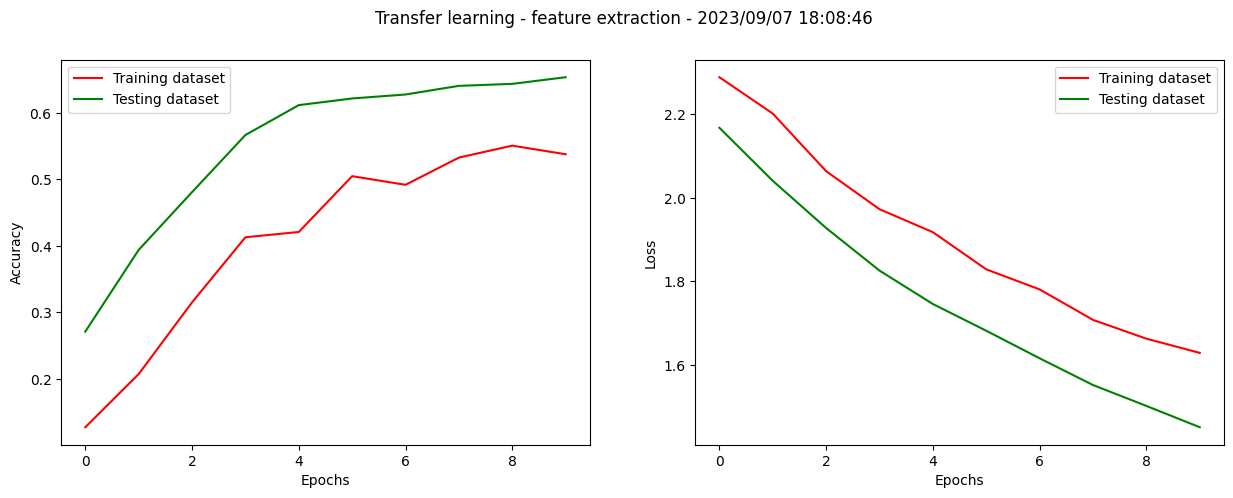

In [16]:
display_history_curves(history_curve_dict=history_curve_feature_extraction_dict, save_path=HISTORY_CURVES_FEATURE_EXTRACTION_PATH, type_name="feature extraction")

`MODEL LOADING`

In [17]:
# samples from val_dataloader
images, labels = next(iter(val_10_percent_dataloader))

# convert to numpy
label = labels.cpu().numpy()

images.shape, labels.shape

(torch.Size([70, 3, 224, 224]), torch.Size([70]))

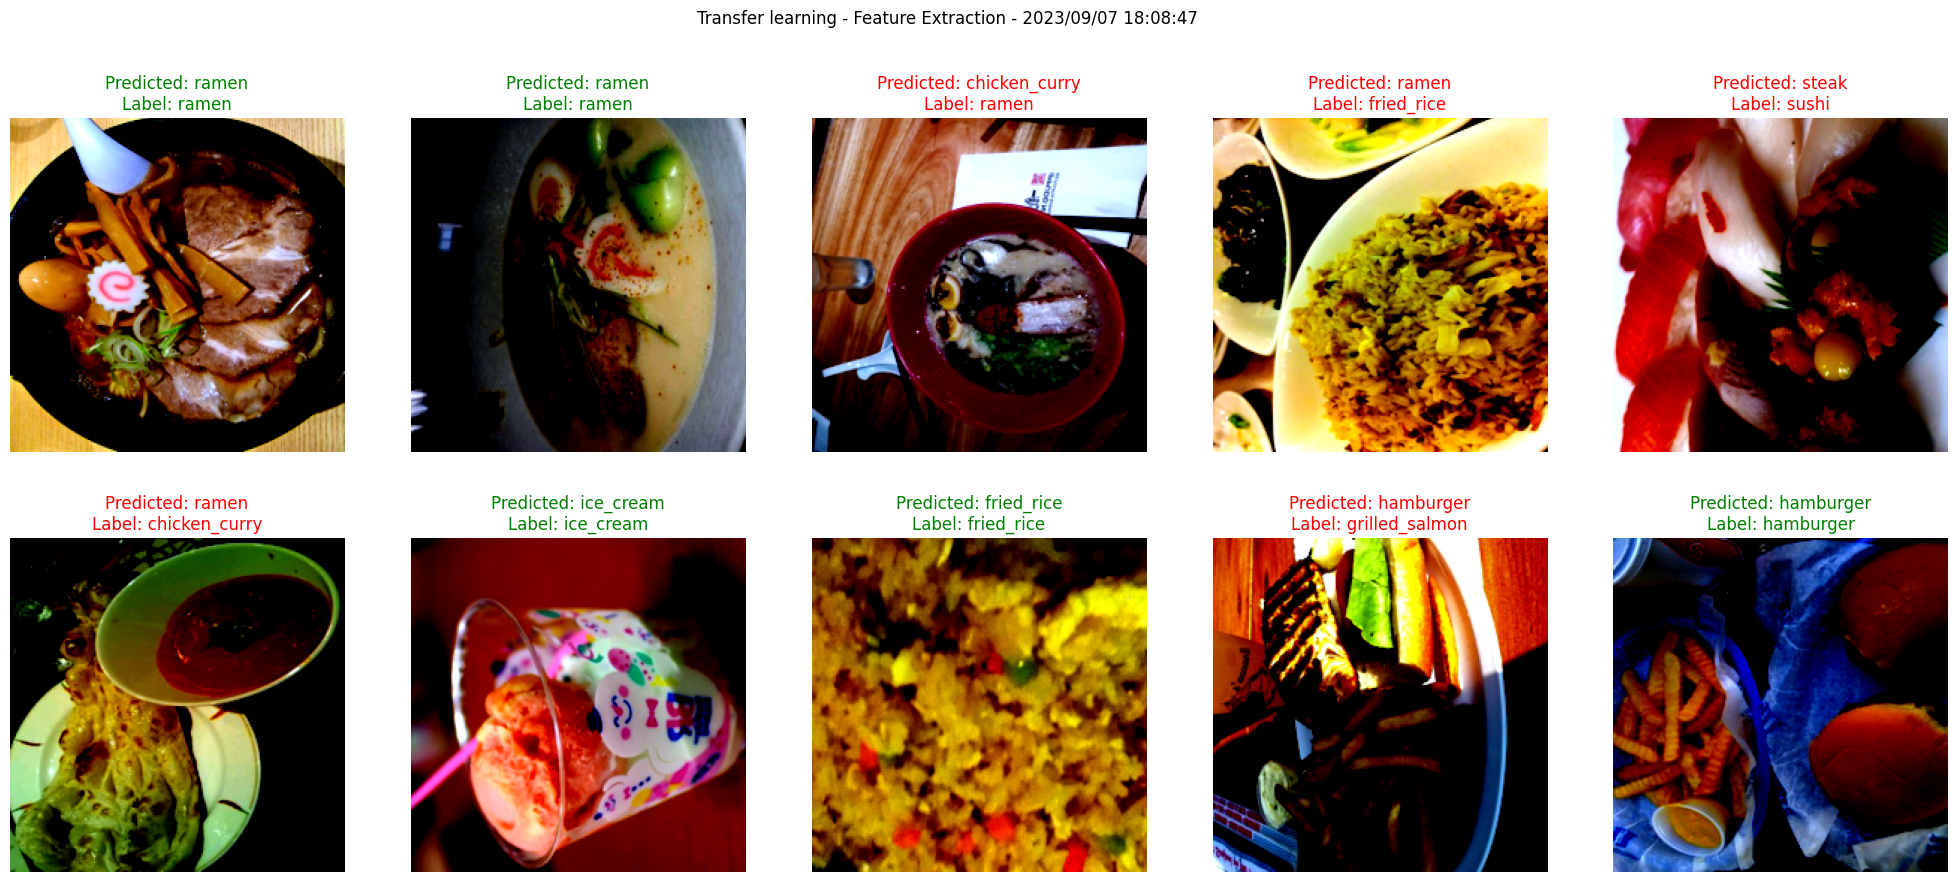

In [18]:
# load a full mode
loaded_feature_extraction_full_model = torch.load(MODEL_FEATURE_EXTRACTION_FULL_MODEL_FILE_PATH)

# send the model to device
loaded_feature_extraction_full_model.to(device)

# eval the loaded model
loaded_feature_extraction_full_model.eval()
with torch.inference_mode():
    y_logits =  loaded_feature_extraction_full_model(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()

# get current date
now_str = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

# plot title
title = f"Transfer learning - Feature Extraction - {now_str}"

# display images with their prediction results
plt.figure(figsize=(25, 10))
plt.suptitle(title)
for i, image in enumerate(images[:10]):
    
    # create a subplot
    plt.subplot(2, len(images[:10]) // 2, i + 1)

    # change the order of dimentions
    image = image.permute((2, 1, 0)).numpy() # (3, 224, 224) -> (224, 224, 3)

    # unnomalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    unnormalized_image = image * std / mean

    # clipping
    clipped_image = np.clip(unnormalized_image, 0, 1)

    # label 
    label = class_names[labels[i]]

    # predicted label
    predicted_label = class_names[y_preds[i]]

    if label == predicted_label:
        title_color = "g"
    else:
        title_color = "r"
    
    # show title
    plt.title(label=f"Predicted: {predicted_label}\nLabel: {label}", color=title_color)

    # disable axis 
    plt.axis(False)

    # display images
    plt.imshow(clipped_image)


#### `FINE TUNING`

In [19]:
# load a full mode
loaded_feature_extraction_full_model = torch.load(MODEL_FEATURE_EXTRACTION_FULL_MODEL_FILE_PATH)

# unfreezing all layers
for name, param in loaded_feature_extraction_full_model.named_parameters():
    param.requires_grad = True

print(summary(model=loaded_feature_extraction_full_model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, 
        row_settings=["var_names"],
        verbose=2))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─0.0.weight                                                                                      ├─864
│    └─0.1.weight                                                                                      ├─32
│    └─0.1.bias                                                                                        ├─32
│    └─1.0.block.0.0.weight                                                                            ├─288
│    └─1.0.block.0.1.weight                                                                            ├─32
│    └─1.0.block.0.1.bias                                         

In [20]:
# get all layers from the features
list_features = []
for name, param in loaded_feature_extraction_full_model.features.named_parameters():
    if param.requires_grad:
        list_features.append(name)

print(f"Total layers before freezing: {len(list_features)}")

# freeze all layers except the last 10 layers
list_features = list_features[:-10]

print(f"Total layers after freezing: {len(list_features)}")
for name, param in loaded_feature_extraction_full_model.features.named_parameters():
    if name in list_features:
        param.requires_grad = False

print(summary(model=loaded_feature_extraction_full_model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, 
        row_settings=["var_names"],
        verbose=2))

Total layers before freezing: 211
Total layers after freezing: 201
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    └─0.0.weight                                                                                      ├─864
│    └─0.1.weight                                                                                      ├─32
│    └─0.1.bias                                                                                        ├─32
│    └─1.0.block.0.0.weight                                                                            ├─288
│    └─1.0.block.0.1.weight                                                                          

In [21]:
# loaded_feature_extraction_full_model = torch.nn.parallel.DataParallel(
#     module=loaded_feature_extraction_full_model, 
#     device_ids=list(range(num_gpus)))

# send model to device 
fine_tuning_efficientnet_b1 = loaded_feature_extraction_full_model.to(device)

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer 
optimizer = torch.optim.Adam(params=fine_tuning_efficientnet_b1.parameters(), lr=0.0001) # 10x lower 

# epochs 
epochs = feature_extraction_epochs + 40

# history curve dict
history_curve_fine_tuning_dict = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": [],
}

## LOOPING
for epoch in tqdm(range(feature_extraction_epochs, epochs)):

    # start timer
    start_timer = timer()

    # TRAINING
    accumulated_train_loss = 0.0
    accumulated_train_accuracy = 0.0
    accumulated_train_batches = 0

    for inputs, outputs in train_full_dataloader:

        # training mode
        fine_tuning_efficientnet_b1.train()

        # send data to device
        inputs, outputs = inputs.to(device), outputs.to(device)

        # forward pass
        y_logits = fine_tuning_efficientnet_b1(inputs)

        # calculate loss
        loss = loss_fn(y_logits, outputs)
        accumulated_train_loss += loss.data

        # calculate accuracy
        acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_accuracy += (acc / len(y_logits))

        # zero gradients
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update weights
        optimizer.step()

        # update batches
        accumulated_train_batches += 1

    # EVALUATION
    fine_tuning_efficientnet_b1.eval()
    with torch.inference_mode():

        accumulated_test_loss = 0.0
        accumulated_test_accuracy = 0.0
        accumulated_test_batches = 0

        for inputs, outputs in test_full_dataloader:


            # send data to device
            inputs, outputs = inputs.to(device), outputs.to(device)

            # forward pass
            y_logits = fine_tuning_efficientnet_b1(inputs)

            # calculate loss
            loss = loss_fn(y_logits, outputs)
            accumulated_test_loss += loss.data

            # calculate accuracy
            acc = torch.eq(outputs, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_accuracy += (acc / len(y_logits))

            # update batches
            accumulated_test_batches += 1
    
    # end timer
    end_timer = timer()
    execution_time = end_timer = start_timer

    # train
    accuracy = accumulated_train_accuracy / accumulated_train_batches
    loss = accumulated_train_loss / accumulated_train_batches

    history_curve_fine_tuning_dict["accuracy"].append(round(accuracy, 3))
    history_curve_fine_tuning_dict["loss"].append(round(loss.cpu().numpy().item(), 3))

    # test
    val_accuracy = accumulated_test_accuracy / accumulated_test_batches
    val_loss = accumulated_test_loss / accumulated_test_batches

    history_curve_fine_tuning_dict["val_accuracy"].append(round(val_accuracy, 3))
    history_curve_fine_tuning_dict["val_loss"].append(round(val_loss.cpu().numpy().item(), 3))

    # print out
    print(f"Epoch: {epoch + 1} / {epochs} | "
          f"Execution time: {execution_time: .2f}s | " 
          f"accuracy: {accuracy: .2f} | "
          f"loss: {loss: .3f} | "
          f"val_accuracy: {val_accuracy: .2f} | "
          f"val_loss: {val_loss: .2f}"
          )

# save the full model
torch.save(fine_tuning_efficientnet_b1, MODEL_FINE_TUNING_FULL_MODEL_FILE_PATH)
if MODEL_FINE_TUNING_FULL_MODEL_FILE_PATH.is_file():
    # getsize() returns in bytes 
    print(f"Size of the full fine tuning model: {os.path.getsize(MODEL_FINE_TUNING_FULL_MODEL_FILE_PATH)  / (1024 * 1024): .2f} MB")

# save the state_dict
torch.save(fine_tuning_efficientnet_b1.state_dict(), MODEL_FINE_TUNING_STATE_DICT_FILE_PATH)
if MODEL_FINE_TUNING_STATE_DICT_FILE_PATH.is_file():
    # getsize() returns in bytes 
     print(f"Size of the state_dict fine tuning model: {os.path.getsize(MODEL_FINE_TUNING_STATE_DICT_FILE_PATH) / (1024 * 1024): .2f} MB")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 / 50 | Execution time:  792719.91s | accuracy:  0.54 | loss:  1.550 | val_accuracy:  0.76 | val_loss:  1.06
Epoch: 12 / 50 | Execution time:  792778.13s | accuracy:  0.60 | loss:  1.344 | val_accuracy:  0.80 | val_loss:  0.85
Epoch: 13 / 50 | Execution time:  792836.03s | accuracy:  0.63 | loss:  1.201 | val_accuracy:  0.81 | val_loss:  0.74
Epoch: 14 / 50 | Execution time:  792893.95s | accuracy:  0.65 | loss:  1.121 | val_accuracy:  0.83 | val_loss:  0.66
Epoch: 15 / 50 | Execution time:  792951.85s | accuracy:  0.67 | loss:  1.069 | val_accuracy:  0.84 | val_loss:  0.62
Epoch: 16 / 50 | Execution time:  793009.73s | accuracy:  0.68 | loss:  1.020 | val_accuracy:  0.84 | val_loss:  0.58
Epoch: 17 / 50 | Execution time:  793068.60s | accuracy:  0.69 | loss:  0.973 | val_accuracy:  0.85 | val_loss:  0.55
Epoch: 18 / 50 | Execution time:  793127.46s | accuracy:  0.68 | loss:  0.977 | val_accuracy:  0.84 | val_loss:  0.54
Epoch: 19 / 50 | Execution time:  793186.35s | accuracy:

In [22]:
def display_history_curves(feature_extraction_history_curve_dict: list, fine_tuning_history_curve_dict: list, intial_epoch: int, save_path: Path, type_name: str = "feature extraction"):

    # get current date
    now_str = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

    # plot title
    title = f"Transfer learning - {type_name} - {now_str}"

    # history curves info
    accuracy = feature_extraction_history_curve_dict["accuracy"] + fine_tuning_history_curve_dict["accuracy"] 
    loss = feature_extraction_history_curve_dict["loss"] + fine_tuning_history_curve_dict["loss"] 
    val_accuracy = feature_extraction_history_curve_dict["val_accuracy"] + fine_tuning_history_curve_dict["val_accuracy"] 
    val_loss = feature_extraction_history_curve_dict["val_loss"] + fine_tuning_history_curve_dict["val_loss"] 

    # list of epochs
    epochs = list(range(len(accuracy)))

    # create a plot 

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    # accuracy of the training set, and testing set
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, c="r", label = "Training dataset")
    plt.plot(epochs, val_accuracy, c="g", label = "Testing dataset")
    plt.plot([intial_epoch, intial_epoch], plt.ylim(), c ="b", label="Start Fine-tuning")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # loss of the training set, and testing set
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, c="r", label = "Training dataset")
    plt.plot(epochs, val_loss, c="g", label = "Testing dataset")
    plt.plot([intial_epoch, intial_epoch], plt.ylim(), c ="b", label="Start Fine-tuning")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.savefig(save_path, bbox_inches="tight")
    print(f"The history curves of the {type_name} is saved in {save_path}")


The history curves of the Fine tuning is saved in ../../logs/06_transfer_learning_feature_extractiion_fine_tuning_20230907/history_curves_fine_tuning_20230907_180537.png


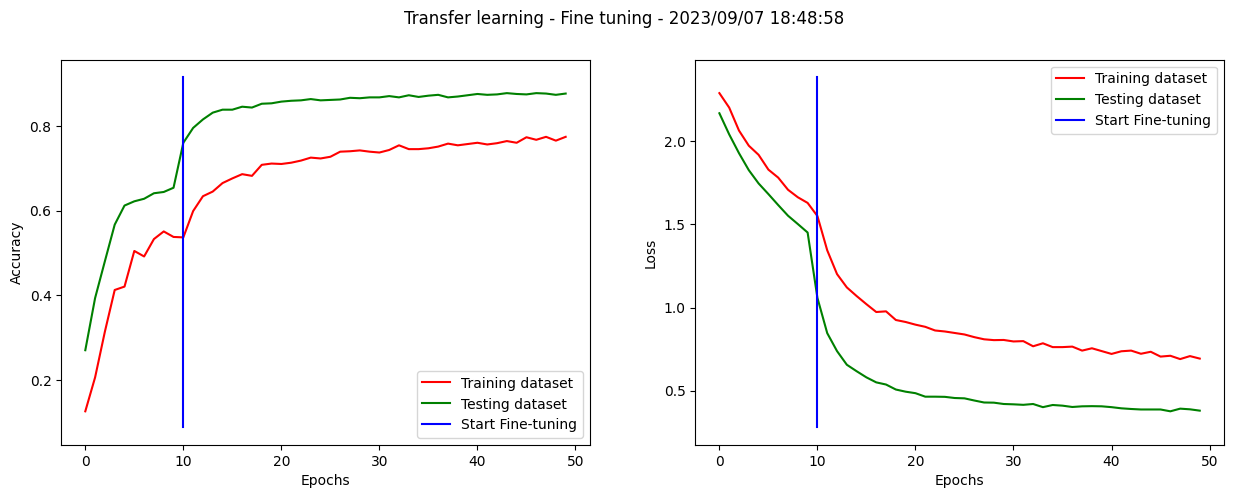

In [25]:
display_history_curves(feature_extraction_history_curve_dict = history_curve_feature_extraction_dict, 
                       fine_tuning_history_curve_dict = history_curve_fine_tuning_dict, intial_epoch = feature_extraction_epochs ,save_path=HISTORY_CURVES_FINE_TUNING_PATH, type_name="Fine tuning")

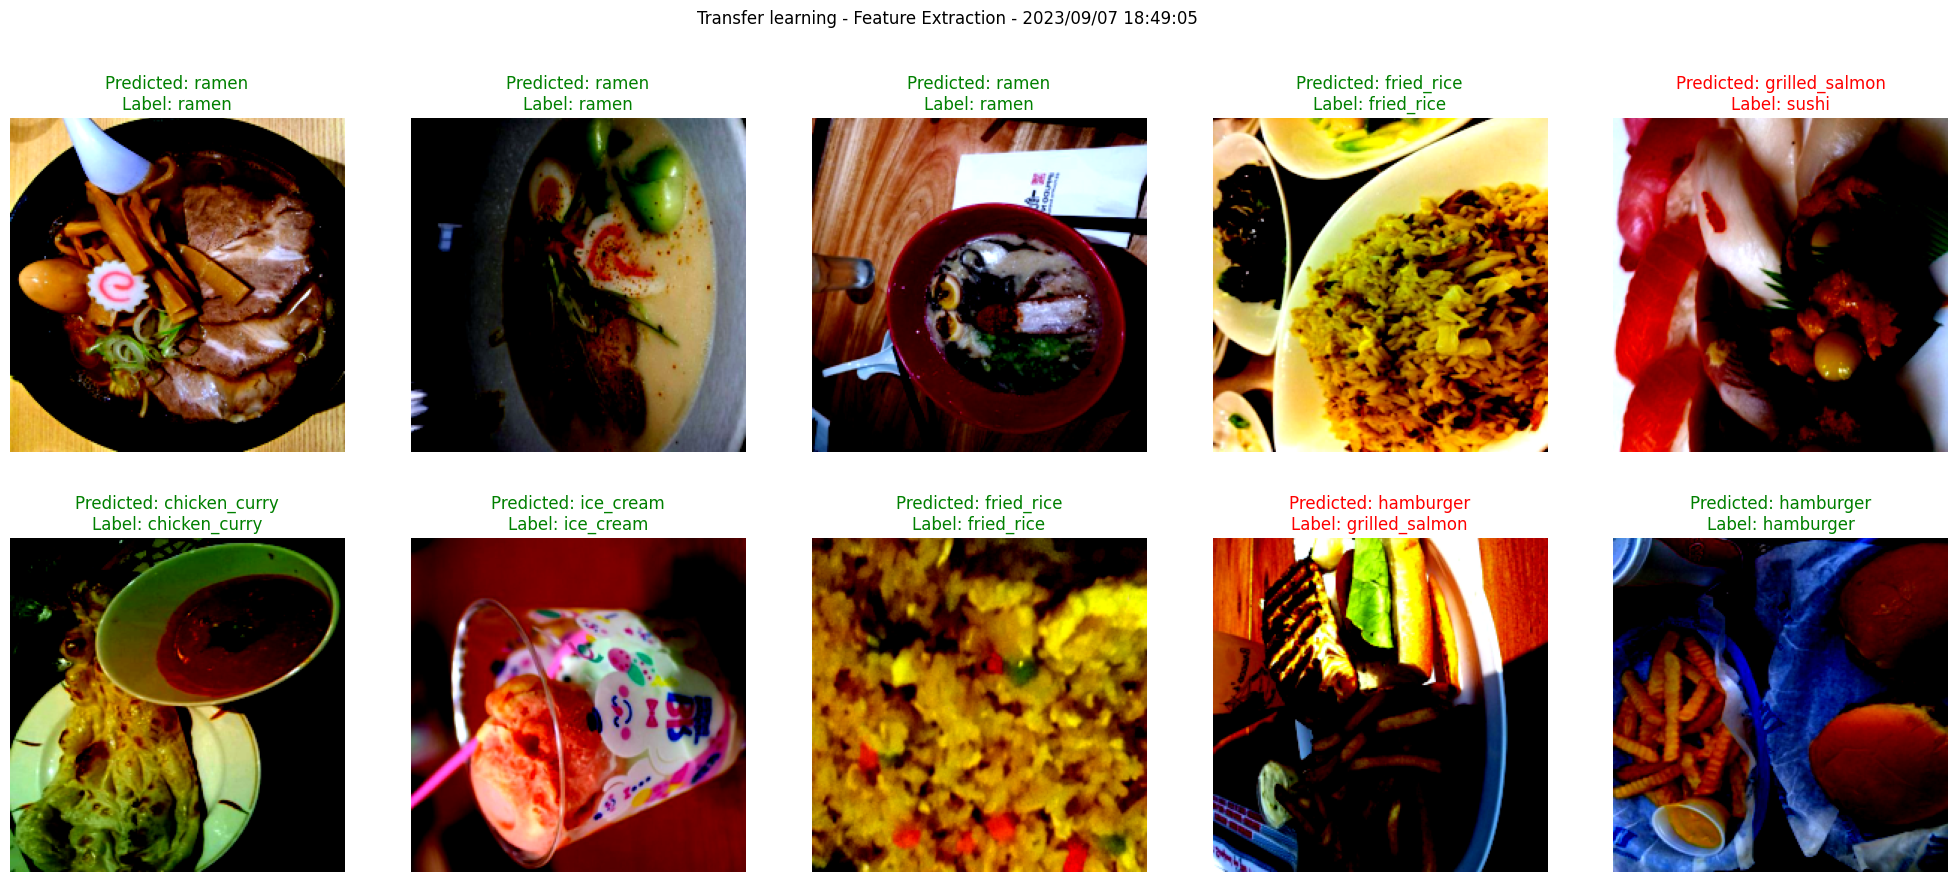

In [26]:
# load a full mode
loaded_fine_tuning_full_model = torch.load(MODEL_FINE_TUNING_FULL_MODEL_FILE_PATH)

# send the model to device
loaded_fine_tuning_full_model.to(device)

# eval the loaded model
loaded_fine_tuning_full_model.eval()
with torch.inference_mode():
    y_logits =  loaded_fine_tuning_full_model(images.to(device))
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1).cpu().numpy()

# get current date
now_str = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

# plot title
title = f"Transfer learning - Feature Extraction - {now_str}"


# display images with their prediction results
plt.figure(figsize=(25, 10))
plt.suptitle(title)
for i, image in enumerate(images[:10]):
    
    # create a subplot
    plt.subplot(2, len(images[:10]) // 2, i + 1)

    # change the order of dimentions
    image = image.permute((2, 1, 0)).numpy() # (3, 224, 224) -> (224, 224, 3)

    # unnomalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    unnormalized_image = image * std / mean

    # clipping
    clipped_image = np.clip(unnormalized_image, 0, 1)

    # label 
    label = class_names[labels[i]]

    # predicted label
    predicted_label = class_names[y_preds[i]]

    if label == predicted_label:
        title_color = "g"
    else:
        title_color = "r"
    
    # show title
    plt.title(label=f"Predicted: {predicted_label}\nLabel: {label}", color=title_color)

    # disable axis 
    plt.axis(False)


    # display images
    plt.imshow(clipped_image)
